In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import json
import os

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from plotly.subplots import make_subplots

import analysis.pipelines.population_spikes as ps
from analysis import metric
from build_input import input_pairs_from_file

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

In [2]:
n_components = 10

# input_type = 'rand'
input_type = 'div'

filter = (input_type, )
exclude = ('baseline', )
standard = ('short', 'long')

# filter += (standard, )
exclude += standard
exclude += ('a03', )

# For division case, fade between assemblies 0, 1 vs 0, 3
# filter = ('div', 'a03')
# filter = ('div', 'a01')
# exclude = None

revert_junction = True

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(trials)

['fade_a01_t0.1_div', 'fade_a01_t0.3_div', 'fade_a01_t1.0_div', 'fade_a01_t3.0_div']


### Load data

In [3]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

unit_rspk = []
for trial in trials:
    PN_spk_file, _ = ps.get_file(trial)
    if os.path.isfile(PN_spk_file): 
        with np.load(PN_spk_file) as f:
            unit_rspk.append(f['unit_fr'][:, f['i_start_fr']:])
    else:
        raise FileNotFoundError(f"Data file {PN_spk_file:s} not created")
unit_rspk = np.concatenate(unit_rspk, axis=1)

In [4]:
pop_ids, trial_info = ps.load_trial(trials[0], ps.PN_pop_names, only_id=True)
PN_node_ids = np.concatenate([pop_ids[p] for p in ps.PN_pop_names])
INPUT_PATH = trial_info[1][0]  # Waring: all trials should share the same input path

# node ids in assemblies
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
n_assy = len(Assembly_ids)
assy_ids = {a: ids for a, ids in enumerate(Assembly_ids)}
assy_names = {a: f'assembly {a:d}' for a in assy_ids}

# get assembly groups if obtained from intrinsic assemblies
div_ids_file = os.path.join(INPUT_PATH, 'Division_ids.csv')
isdivision = os.path.isfile(div_ids_file)
if isdivision:
    div_id = pd.read_csv(div_ids_file, index_col='division_id')['assembly_id']
    assy_div = {v: div_id[div_id == v].index.tolist() for v in div_id.unique()}
    assy_ids_disp = [a for ids in assy_div.values() for a in ids]
else:
    assy_ids_disp = list(assy_ids)
assy_names_disp = [assy_names[a] for a in assy_ids_disp]

### Process PCA

In [5]:
# Assembly direction vectors of assemblies
PN_idx = pd.Series(range(len(PN_node_ids)), index=PN_node_ids)
assy_dvec = np.zeros((n_assy, PN_idx.size))
for i, ids in enumerate(Assembly_ids):
    assy_dvec[i, PN_idx[ids]] = 1
inactive_units = ~np.any(unit_rspk, axis=1)
assy_dvec[:, inactive_units] = 0  # remove inactivate units

In [6]:
# PCA
n_components = n_assy + 1
pca = PCA(n_components=n_components)
pca.fit(unit_rspk.T)

PCA(n_components=10)

In [7]:
# Cosine similarity between PCs and assembly direction vectors
cosvec_mat = np.abs(cosine_similarity(pca.components_, assy_dvec))
cosvec = pd.DataFrame(cosvec_mat[:, assy_ids_disp], columns=assy_names_disp,
                      index=pd.Index(range(pca.components_.shape[0]), name='PCs'))
cosvec['max'] = cosvec.max(axis=1)
cosvec['max_assembly'] = [cosvec.columns[i] for i in np.argmax(cosvec.values, axis=1)]
cosvec['total projection'] = np.linalg.norm(cosvec_mat, axis=1)
assy2pc_proj = np.linalg.norm(cosvec_mat[:n_assy], axis=0)

P_angles, Gr_dist = metric.principal_angles(pca.components_[:n_assy], assy_dvec, rowspace=True)

### Plots

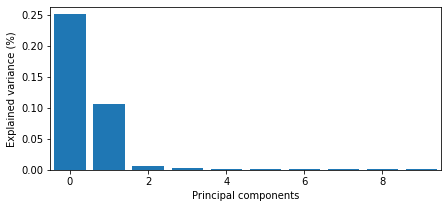

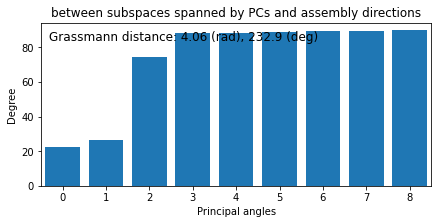

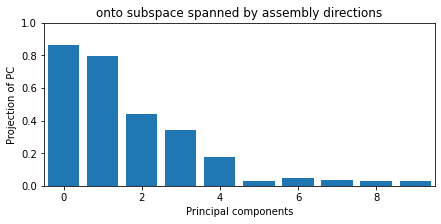

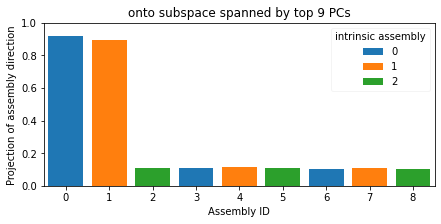

In [8]:
# Explained variance
plt.figure(figsize=(7, 3))
plt.bar(range(n_components), pca.explained_variance_ratio_)
plt.xlim(-0.5, n_components - 0.5)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')

# Distance between PC subspace and assembly subspace
plt.figure(figsize=(7, 3))
plt.bar(range(n_assy), 180 / np.pi * P_angles)
plt.text(0.02, 0.95, 'Grassmann distance: '
         '%.2f (rad), %.1f (deg)' % (Gr_dist, 180 / np.pi *  Gr_dist),
         transform=plt.gca().transAxes, fontsize='large',
         horizontalalignment='left', verticalalignment='top')
plt.xlim(-0.5, n_assy - 0.5)
plt.xlabel('Principal angles')
plt.ylabel('Degree')
plt.title('between subspaces spanned by PCs and assembly directions')

# Projection of PCs and assembly directions onto the each other's subspace
plt.figure(figsize=(7, 3))
plt.bar(range(n_components), cosvec['total projection'])
plt.xlim(-0.5, n_components - 0.5)
plt.ylim(0, 1)
plt.xlabel('Principal components')
plt.ylabel('Projection of PC')
plt.title('onto subspace spanned by assembly directions')

plt.figure(figsize=(7, 3))
if isdivision:
    for i, ids in assy_div.items():
        plt.bar(ids, assy2pc_proj[ids], label=str(i))
    plt.legend(title='intrinsic assembly', loc='upper right', framealpha=0.2)
else:
    plt.bar(range(n_assy), assy2pc_proj)
plt.xlim(-0.5, n_assy - 0.5)
plt.ylim(0, 1)
plt.xlabel('Assembly ID')
plt.ylabel('Projection of assembly direction')
plt.title(f'onto subspace spanned by top {n_assy:d} PCs')

plt.show()

In [9]:
assy_names_radar = assy_names_disp + [assy_names_disp[0]]
PC_names_radar = [f'PC {i:d}' for i in range(n_components)]
PC_names_radar = PC_names_radar + [PC_names_radar[0]]
PC_idx_radar = list(range(n_components)) + [0]
cmap = px.colors.sample_colorscale('thermal', np.linspace(0, 1, n_components))[::-1]
if isdivision:
    cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, \
        max(len(ids) for ids in assy_div.values())))[::-1]
else:
    cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, n_assy))[::-1]
rotation = 130 if isdivision else 90
maxcos = cosvec[assy_names_disp].values.max()

fig = go.Figure()
for i in range(n_components)[::-1]:
    fig.add_trace(go.Scatterpolar(
        name=PC_names_radar[i], r=cosvec.loc[i, assy_names_radar],
        theta=assy_names_radar, mode='lines', line_color=cmap[i]
    ))
fig.update_polars(
    gridshape = 'linear',
    angularaxis = dict(rotation=rotation, direction="clockwise"),
    radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
)
fig.update_layout(
    width=600, height=400, margin=dict(l=10, r=100, t=60, b=20),
    title = dict(text='Cosine similarity between PCs and assembly directions', x=0.5),
    legend = dict(traceorder='reversed', xanchor='left', x=1.0, y=0.5)
)
fig.show()

if isdivision:
    n_int_assy = len(assy_div)
    fig = make_subplots(
        rows=1, cols=n_int_assy, specs=[[{'type': 'polar'}] * n_int_assy],
        subplot_titles=[f'intrinsic assembly {a:d}' for a in assy_div],
        horizontal_spacing=0.0
    )
    for i, ids in enumerate(assy_div.values()):
        for j in range(len(ids)):
            fig.add_trace(go.Scatterpolar(name=assy_names[ids[j]],
                r=cosvec.loc[PC_idx_radar, assy_names[ids[j]]],
                theta=PC_names_radar, mode='lines', line_color=cmap2[j],
                legendgroup=i, legendgrouptitle_text=f'intrinsic assembly {i:d}'
            ), row=1, col=i + 1)
    fig.update_layout(width=1200, height=360, margin=dict(l=10, r=120, t=50, b=30))
    for annotation in fig['layout']['annotations']: 
        annotation['y'] = 1.08
else:
    fig = go.Figure()
    for i in range(n_assy):
        fig.add_trace(go.Scatterpolar(name=assy_names_disp[i],
            r=cosvec.loc[PC_idx_radar, assy_names_disp[i]],
            theta=PC_names_radar, mode='lines', line_color=cmap2[i]
        ))
    fig.update_layout(width=600, height=400, margin=dict(l=10, r=100, t=40, b=40))
fig.update_polars(
    gridshape = 'linear',
    angularaxis = dict(rotation=90, direction="clockwise"),
    radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
)
fig.update_layout(legend=dict(xanchor='left', x=1.0, y=0.5))
fig.show()

print("Alignment (cosine similarity) between PCs and assembly directions")
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(cosvec)

Alignment (cosine similarity) between PCs and assembly directions


,assembly 0,assembly 3,assembly 6,assembly 1,assembly 4,assembly 7,assembly 2,assembly 5,assembly 8,max,max_assembly,total projection
PCs,,,,,,,,,,,,
0,0.611,0.006,0.006,0.610,0.001,0.001,0.002,0.002,0.002,0.611,assembly 0,0.864
1,0.564,0.051,0.051,0.545,0.058,0.055,0.060,0.061,0.058,0.564,assembly 0,0.799
2,0.392,0.052,0.051,0.162,0.039,0.041,0.038,0.041,0.039,0.392,assembly 0,0.439
3,0.045,0.058,0.055,0.290,0.081,0.076,0.062,0.074,0.058,0.290,assembly 1,0.343
4,0.027,0.045,0.048,0.136,0.040,0.033,0.048,0.038,0.044,0.136,assembly 1,0.179
5,0.000,0.016,0.003,0.015,0.006,0.012,0.005,0.004,0.004,0.016,assembly 3,0.027
6,0.007,0.003,0.005,0.043,0.007,0.004,0.005,0.005,0.018,0.043,assembly 1,0.049
7,0.007,0.016,0.023,0.018,0.003,0.002,0.007,0.001,0.012,0.023,assembly 6,0.037
8,0.007,0.016,0.007,0.012,0.002,0.006,0.012,0.009,0.009,0.016,assembly 3,0.029
